In [255]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [256]:
device = tc.device("cpu")

# Load data:

In [277]:
data = np.load('data/test_data_elemental_lines/XRF_sample1.npy')
print(data.shape)

(12, 30, 8)


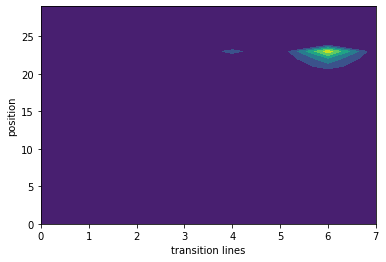

In [258]:
plt.contourf(data[0,:,:]) # Third angle:
plt.xlabel('transition lines')
plt.ylabel('position')
plt.show()

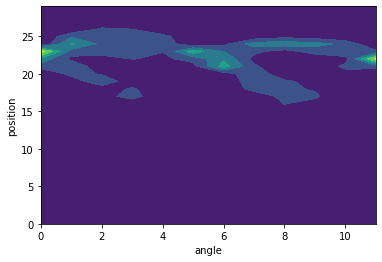

In [259]:
plt.contourf(data[:,:,6].transpose()) # Third angle:
plt.xlabel('angle')
plt.ylabel('position')
plt.show()

# Test how reshape works:

# Make mini-batch:

In [261]:
n_minibatch=5
minibatch_size = data[0].shape[0]//n_minibatch

# Take first angle:
angle = data[0]
print(angle.shape)

# Reshape
y = angle.reshape(n_minibatch, minibatch_size, -1)
y.shape

(30, 8)


(5, 6, 8)

# Inherit nn.Module to make our own model:

In [269]:
class PPM(nn.Module):
    def __init__(self, p):
        """
        Initialize the attributes of PPM. 
        """
        super(PPM, self).__init__() # inherit the __init__ from nn.Module.
        self.p = p  # indicate which minibatch to calculate the gradient  
        self.xp = self.init_xp() # initialize the values of the minibatch
        
    def init_xp(self):
        """
        Initialize self.x with 5x6x30 zero tensor. 
        """
        return nn.Parameter(tc.zeros(5, 6, 30))

        
    def forward(self, X):  # convert X to y_hat; dimension changes from (5, 30, 30) to (30, 8)
        """
        Forward propagation.
        """
        X[:, 6*self.p:6*(self.p+1), :] = self.xp
        X = tc.sum(X, axis=2)
        h1 =  tc.randn(30, 8)
        h2 =  tc.randn(30, 5)
        output = tc.matmul(h2, tc.matmul(X, h1))
        
#         output = X
        return output

In [270]:
X = tc.randn(5, 30, 30)
X = tc.sum(X, axis =2)
print(X.shape)

h1 = tc.zeros(30, 8)
h = tc.matmul(X, h1)

h2 = tc.zeros(30, 5)
h = tc.matmul(h2, h)

print(h.shape)

torch.Size([5, 30])
torch.Size([30, 8])


In [271]:
X = tc.randn(5,30,30)
X_sum = tc.sum(X, dim = 2)
print(h_sum.shape)

m1 = tc.zeros(30, 5)
print(m1.shape)
m2 = tc.zeros(30, 8)
print(m2.shape)

print(tc.matmul(tc.matmul(m1, h_sum), m2).shape)

torch.Size([5, 30])
torch.Size([30, 5])
torch.Size([30, 8])
torch.Size([30, 8])


In [272]:
model = [PPM(m) for m in range(n_minibatch)]
list(model[0].parameters())[0].shape

torch.Size([5, 6, 30])

In [285]:
# y_true = tc.tensor(angle)

y_true = tc.randn(30, 8)
# y_true = tc.randn(5, 30, 30)

X = tc.ones(5, 30, 30)

loss_fn = nn.MSELoss()
optimizer = [tc.optim.Adam(model[m].parameters(), lr=0.01) for m in range(n_minibatch)]

    
for m in range(n_minibatch):
    
    y_hat = model[m](X)
    loss = loss_fn(y_hat, y_true)
    
    optimizer[m].zero_grad()
    loss.backward()
    optimizer[m].step()
    
#     print(model[m].xp)
    print(y_hat)
    X[:, minibatch_size*m:minibatch_size*(m+1),:] = model[m].xp
    X = tc.tensor(X.detach().numpy())
    

    # Check whether model.parameters() is model.x
#     print('Is model.parameters()= model.x?', list(model.parameters())[0] is model.x, '\n') # or print(list(model.parameters())[0] == model.x)
#     print('Print model.x', model.x, '\n')
#     print('Loss for angle {}: {}'.format(i, loss.item()) )

tensor([[   71.1004,  -375.1943,  -382.2452,  1121.1023,   245.4089, -1215.6779,
          -548.6149,   420.4432],
        [   17.0814,   -90.1380,   -91.8320,   269.3377,    58.9579,  -292.0588,
          -131.8012,   101.0088],
        [  -15.8022,    83.3876,    84.9546,  -249.1668,   -54.5425,   270.1864,
           121.9306,   -93.4442],
        [   21.2903,  -112.3483,  -114.4596,   335.7031,    73.4853,  -364.0228,
          -164.2773,   125.8976],
        [  -18.3397,    96.7778,    98.5965,  -289.1776,   -63.3009,   313.5725,
           141.5100,  -108.4493],
        [  -34.1725,   180.3272,   183.7160,  -538.8282,  -117.9493,   584.2834,
           263.6772,  -202.0749],
        [   10.0846,   -53.2162,   -54.2163,   159.0131,    34.8079,  -172.4274,
           -77.8135,    59.6341],
        [    4.3595,   -23.0050,   -23.4373,    68.7403,    15.0472,   -74.5392,
           -33.6383,    25.7795],
        [    6.3223,   -33.3627,   -33.9897,    99.6898,    21.8221,  -108.0996,

torch.Size([30, 8])


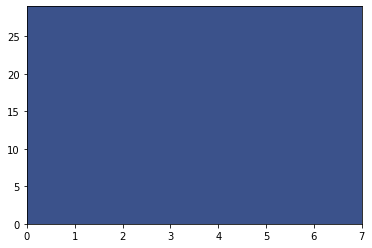

In [286]:
Y = model[0](X)
print(Y.shape)
plt.contourf(Y.detach().numpy()) # Remember to detach from the computational graph and convert to numpy in order
                                 # to make plot.
plt.show()